In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
pd.options.mode.chained_assignment = None
style.use('ggplot') or plt.style.use('ggplot')


### Units used are as in Elmer/Ice:

MPa, a, m
 


In [2]:
# Conversion to Elmer/Ice units

yearinsec = 365.25*24*60*60
rhoi = 900.0/(1.0e6*yearinsec**2)
rhow = 1000.0/(1.0e6*yearinsec**2)
g = -9.8*yearinsec**2


In [3]:
# Lists of fluxes, sigma values (in bed elevation equation) and simulation names

fluxes = [100, 200, 300, 400, 500]
sigmas = [4000, 8000, 12000, 16000]
sims = []

for i in fluxes:
    for j in sigmas:
        sims.append('Flux' + str(i) + 'Sigma' + str(j))


dfs = {}
for sim in sims:
    dfs[sim] = pd.read_csv('../Data/Stress/' + str(sim) + 'm45000.csv')


In [4]:
# Calculate the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']


In [5]:
# Re-order data by the y-coordinate and the z-coordinate

for sim in sims:
    dfs[sim]['Points:1'] = dfs[sim]['Points:1']
    dfs[sim] = dfs[sim].sort_values(by=['Points:1', 'Points:2'])
    dfs[sim] = dfs[sim].reset_index(drop=True)
    

In [6]:
# Create dataframe column for the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']


In [7]:
# Calculate the hydrostatic pressure at a point if the ice shelf ended at that point

for sim in sims:
    dfs[sim]['hyd. pressure'] = [0] * len(dfs[sim])

for sim in sims:
    for i in range(len(dfs[sim])):
        if dfs[sim]['Points:2'][i] < 0.0:
            dfs[sim]['hyd. pressure'][i] = - rhow * g * dfs[sim]['Points:2'][i]
        else:
            dfs[sim]['hyd. pressure'][i] = 0.0
    
# Subtract the hydrostatic pressure from stess

for sim in sims:
    dfs[sim]['stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure']
    dfs[sim]['dev stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']


True -1.8414200000000003
-1.8414200000000003
True -1.613374
-1.613374
True -1.3853280000000003
-1.3853280000000003
True -1.1572820000000001
-1.1572820000000001
True -0.9292752000000001
-0.9292752000000001
True -0.7012292000000001
-0.7012292000000001
True -0.47319300000000003
-0.47319300000000003
True -0.24514700000000003
-0.24514700000000003
True -0.017108840000000004
-0.017108840000000004
0.0
True -1.8414200000000003
-1.8414200000000003
True -1.613374
-1.613374
True -1.3853280000000003
-1.3853280000000003
True -1.1572820000000001
-1.1572820000000001
True -0.9292458000000001
-0.9292458000000001
True -0.7012096000000002
-0.7012096000000002
True -0.4731734000000001
-0.4731734000000001
True -0.24514700000000003
-0.24514700000000003
True -0.017108840000000004
-0.017108840000000004
0.0
True -1.8404400000000003
-1.8404400000000003
True -1.6124920000000003
-1.6124920000000003
True -1.3845440000000002
-1.3845440000000002
True -1.156694
-1.156694
True -0.9287656000000002
-0.9287656000000002
Tru

True -1.052324
-1.052324
True -0.7941626000000002
-0.7941626000000002
True -0.535962
-0.535962
True -0.27776140000000005
-0.27776140000000005
True -0.01956472
-0.01956472
0.0
True -2.086028
-2.086028
True -1.8277000000000003
-1.8277000000000003
True -1.569372
-1.569372
True -1.311142
-1.311142
True -1.0528140000000001
-1.0528140000000001
True -0.794486
-0.794486
True -0.5361874000000001
-0.5361874000000001
True -0.27787900000000004
-0.27787900000000004
True -0.019574520000000005
-0.019574520000000005
0.0
True -2.08936
-2.08936
True -1.8306400000000003
-1.8306400000000003
True -1.5719200000000002
-1.5719200000000002
True -1.3132000000000001
-1.3132000000000001
True -1.05448
-1.05448
True -0.7957600000000001
-0.7957600000000001
True -0.5370400000000001
-0.5370400000000001
True -0.27832
-0.27832
True -0.019605880000000003
-0.019605880000000003
0.0
True -2.0921040000000004
-2.0921040000000004
True -1.8330900000000003
-1.8330900000000003
True -1.5739780000000003
-1.5739780000000003
True -1.

-0.020617240000000005
0.0
True -2.1890260000000006
-2.1890260000000006
True -1.9179580000000003
-1.9179580000000003
True -1.6469880000000003
-1.6469880000000003
True -1.3759200000000003
-1.3759200000000003
True -1.1048520000000002
-1.1048520000000002
True -0.8337742
-0.8337742
True -0.5627258
-0.5627258
True -0.2916676
-0.2916676
True -0.02061038
-0.02061038
0.0
True -2.1879480000000004
-2.1879480000000004
True -1.9170760000000002
-1.9170760000000002
True -1.6461060000000003
-1.6461060000000003
True -1.3752340000000003
-1.3752340000000003
True -1.1042640000000001
-1.1042640000000001
True -0.8333724000000001
-0.8333724000000001
True -0.5624514
-0.5624514
True -0.2915402
-0.2915402
True -0.02061626
-0.02061626
0.0
True -2.1879480000000004
-2.1879480000000004
True -1.9169780000000005
-1.9169780000000005
True -1.6461060000000003
-1.6461060000000003
True -1.3751360000000001
-1.3751360000000001
True -1.1042640000000001
-1.1042640000000001
True -0.8333528000000001
-0.8333528000000001
True -0.

-2.3359280000000004
True -2.04673
-2.04673
True -1.7575320000000003
-1.7575320000000003
True -1.468236
-1.468236
True -1.1790380000000003
-1.1790380000000003
True -0.8898008000000002
-0.8898008000000002
True -0.6005734000000001
-0.6005734000000001
True -0.31134600000000007
-0.31134600000000007
True -0.022110760000000004
-0.022110760000000004
0.0
True -2.331812
-2.331812
True -2.043104
-2.043104
True -1.7543960000000003
-1.7543960000000003
True -1.4655900000000004
-1.4655900000000004
True -1.1768820000000002
-1.1768820000000002
True -0.8882034000000001
-0.8882034000000001
True -0.5994856000000001
-0.5994856000000001
True -0.31076780000000004
-0.31076780000000004
True -0.022046080000000003
-0.022046080000000003
0.0
True -2.3275
-2.3275
True -2.0392820000000005
-2.0392820000000005
True -1.7510640000000004
-1.7510640000000004
True -1.4629440000000002
-1.4629440000000002
True -1.1747260000000002
-1.1747260000000002
True -0.8865570000000002
-0.8865570000000002
True -0.5983782000000001
-0.598

True -0.30255540000000003
-0.30255540000000003
True -0.021447300000000002
-0.021447300000000002
0.0
True -2.26772
-2.26772
True -1.9869500000000002
-1.9869500000000002
True -1.7061800000000003
-1.7061800000000003
True -1.42541
-1.42541
True -1.1445420000000002
-1.1445420000000002
True -0.8637916000000001
-0.8637916000000001
True -0.5829922000000001
-0.5829922000000001
True -0.30220260000000004
-0.30220260000000004
True -0.021408100000000003
-0.021408100000000003
0.0
True -2.2643880000000003
-2.2643880000000003
True -1.9840100000000003
-1.9840100000000003
True -1.7036320000000003
-1.7036320000000003
True -1.423254
-1.423254
True -1.1428760000000002
-1.1428760000000002
True -0.8625078
-0.8625078
True -0.5821396000000001
-0.5821396000000001
True -0.3017616000000001
-0.3017616000000001
True -0.02138556
-0.02138556
0.0
True -2.2641920000000004
-2.2641920000000004
True -1.9838140000000004
-1.9838140000000004
True -1.7034360000000002
-1.7034360000000002
True -1.423156
-1.423156
True -1.142778

-1.4307020000000004
True -1.1488540000000003
-1.1488540000000003
True -0.8670158000000001
-0.8670158000000001
True -0.5851776000000001
-0.5851776000000001
True -0.30333940000000004
-0.30333940000000004
True -0.0214963
-0.0214963
0.0
True -2.277422
-2.277422
True -1.9953780000000003
-1.9953780000000003
True -1.7134320000000003
-1.7134320000000003
True -1.431486
-1.431486
True -1.1494420000000003
-1.1494420000000003
True -0.8674764000000001
-0.8674764000000001
True -0.5854814000000002
-0.5854814000000002
True -0.30349620000000005
-0.30349620000000005
True -0.021510020000000005
-0.021510020000000005
0.0
True -2.2801660000000004
-2.2801660000000004
True -1.9978280000000004
-1.9978280000000004
True -1.7154900000000004
-1.7154900000000004
True -1.4331520000000002
-1.4331520000000002
True -1.1508140000000002
-1.1508140000000002
True -0.8685152
-0.8685152
True -0.586187
-0.586187
True -0.30385880000000004
-0.30385880000000004
True -0.021537460000000005
-0.021537460000000005
0.0
True -2.2812440

True -0.023565080000000002
-0.023565080000000002
0.0
True -2.484986
-2.484986
True -2.1773640000000003
-2.1773640000000003
True -1.8696440000000003
-1.8696440000000003
True -1.562022
-1.562022
True -1.254302
-1.254302
True -0.9466310000000001
-0.9466310000000001
True -0.6389502
-0.6389502
True -0.33127920000000005
-0.33127920000000005
True -0.023603300000000004
-0.023603300000000004
0.0
True -2.488122
-2.488122
True -2.1800100000000002
-2.1800100000000002
True -1.8719960000000004
-1.8719960000000004
True -1.5638840000000003
-1.5638840000000003
True -1.2558700000000003
-1.2558700000000003
True -0.9478266000000001
-0.9478266000000001
True -0.6397734000000002
-0.6397734000000002
True -0.3317202
-0.3317202
True -0.023665040000000005
-0.023665040000000005
0.0
True -2.490866
-2.490866
True -2.1824600000000003
-2.1824600000000003
True -1.874054
-1.874054
True -1.5656480000000002
-1.5656480000000002
True -1.2572420000000002
-1.2572420000000002
True -0.9488948
-0.9488948
True -0.640498600000000

True -0.9112922000000002
-0.9112922000000002
True -0.6150872000000002
-0.6150872000000002
True -0.31888220000000006
-0.31888220000000006
True -0.022670340000000004
-0.022670340000000004
0.0
True -2.3931600000000004
-2.3931600000000004
True -2.096906
-2.096906
True -1.8005540000000002
-1.8005540000000002
True -1.5043000000000002
-1.5043000000000002
True -1.2079480000000002
-1.2079480000000002
True -0.9116254000000001
-0.9116254000000001
True -0.6153126000000001
-0.6153126000000001
True -0.31899980000000006
-0.31899980000000006
True -0.02268896
-0.02268896
0.0
True -2.3933560000000003
-2.3933560000000003
True -2.0971020000000005
-2.0971020000000005
True -1.8007500000000003
-1.8007500000000003
True -1.5043980000000001
-1.5043980000000001
True -1.2080460000000002
-1.2080460000000002
True -0.9117038000000002
-0.9117038000000002
True -0.6153714000000001
-0.6153714000000001
True -0.31902920000000007
-0.31902920000000007
True -0.022696800000000003
-0.022696800000000003
0.0
True -2.393748000000

-2.1588420000000004
True -1.8537680000000003
-1.8537680000000003
True -1.5486940000000002
-1.5486940000000002
True -1.2436200000000002
-1.2436200000000002
True -0.9385852000000001
-0.9385852000000001
True -0.6335308000000001
-0.6335308000000001
True -0.32846660000000005
-0.32846660000000005
True -0.02340044
-0.02340044
0.0
True -2.4610740000000004
-2.4610740000000004
True -2.1562940000000004
-2.1562940000000004
True -1.8516120000000003
-1.8516120000000003
True -1.5469300000000001
-1.5469300000000001
True -1.2422480000000002
-1.2422480000000002
True -0.9375072000000001
-0.9375072000000001
True -0.6327958
-0.6327958
True -0.32809420000000006
-0.32809420000000006
True -0.023388680000000005
-0.023388680000000005
0.0
True -2.4608780000000006
-2.4608780000000006
True -2.1561960000000004
-2.1561960000000004
True -1.8515140000000003
-1.8515140000000003
True -1.5468320000000002
-1.5468320000000002
True -1.24215
-1.24215
True -0.9374386000000001
-0.9374386000000001
True -0.6327566
-0.6327566
Tru

In [8]:
dfs[sim]

,pressure,stress 1,stress 2,stress 3,stress 4,stress 5,stress 6,depth,height,velocity:0,...,velocity:2,Points:0,Points:1,Points:2,dev stress 1,dev stress 2,dev stress 3,hyd. pressure,stress 1 - hyd. p.,dev stress 1 - hyd. p.
0,2.562700,-2.502100,-2.622800,-2.563200e+00,-0.000870,-9.120900e-06,2.939900e-05,554.13,0.00,601.30,...,-1.2232,-45000,-75000.0,-260.8000,0.060600,-0.060100,-0.000500,-2.555840,0.053740,2.616440
1,2.277900,-2.217300,-2.338000,-2.278400e+00,-0.000870,-7.437800e-06,2.306900e-05,521.84,32.29,601.30,...,-1.2240,-45000,-75000.0,-228.5100,0.060600,-0.060100,-0.000500,-2.239398,0.022098,2.299998
2,1.993100,-1.932500,-2.053200,-1.993600e+00,-0.000870,-5.757500e-06,2.048800e-05,489.55,64.58,601.30,...,-1.2249,-45000,-75000.0,-196.2200,0.060600,-0.060100,-0.000500,-1.922956,-0.009544,1.983556
3,1.708300,-1.647700,-1.768400,-1.708800e+00,-0.000870,-4.076100e-06,1.691000e-05,457.26,96.87,601.30,...,-1.2257,-45000,-75000.0,-163.9300,0.060600,-0.060100,-0.000500,-1.606514,-0.041186,1.667114
4,1.423500,-1.362900,-1.483600,-1.424000e+00,-0.000870,-2.394800e-06,1.361300e-05,424.97,129.16,601.30,...,-1.2265,-45000,-75000.0,-131.6400,0.060600,-0.060100,-0.000500,-1.290072,-0.072828,1.350672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,1.138100,-1.077600,-1.198100,-1.138600e+00,0.000839,-7.570400e-07,1.008800e-05,-1064.80,161.37,600.93,...,-1.2273,-45000,75000.0,-99.3030,0.060500,-0.060000,-0.000500,-0.973169,-0.104431,1.033669
1687,0.853460,-0.792930,-0.913480,-8.539500e-01,0.000839,-1.568800e-06,6.843200e-06,-1097.10,193.64,600.93,...,-1.2281,-45000,75000.0,-67.0300,0.060530,-0.060020,-0.000490,-0.656894,-0.136036,0.717424
1688,0.568810,-0.508280,-0.628830,-5.693000e-01,0.000839,-2.379500e-06,3.354900e-06,-1129.30,225.91,600.93,...,-1.2290,-45000,75000.0,-34.7570,0.060530,-0.060020,-0.000490,-0.340619,-0.167661,0.401149
1689,0.284150,-0.223630,-0.344180,-2.846500e-01,0.000839,-3.188400e-06,8.039600e-07,-1161.60,258.19,600.93,...,-1.2298,-45000,75000.0,-2.4831,0.060520,-0.060030,-0.000500,-0.024334,-0.199296,0.084854


In [9]:
# Function to vertically integrate data
# As input, it takes a dataframe, number of vertical nodes, variable and coordinate of interest

def VertInt(df, N, var, coord):
    field = dict.fromkeys(df[coord], 0)
    Coord = dict.fromkeys(df[coord], 0)
    for i in df[coord]:
        Coord[i] += 1
    incorrect_coord_values = [k for k, v in Coord.items() if v != 10]
    correct_coord_values = [k for k, v in Coord.items() if v == 10]
    for i in incorrect_coord_values:
        Coord = {i:Coord[i] for i in Coord if i not in incorrect_coord_values}
    df_height0 = df[df['height'] < 0.1]
    df_depth0 = df[df['pressure'] < 0.1]
    df_other = df[df['height'] > 0.1]
    df_other = df_other[df_other['pressure'] > 0.1]
    df_height0 = df_height0.reset_index(drop=True)
    df_depth0 = df_depth0.reset_index(drop=True)
    df_other = df_other.reset_index(drop=True)
    for i in range(len(df_height0)):
        field[df_height0[coord][i]] += 0.5 * df_height0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] += 0.5 * df_depth0[var][i]
    for i in range(len(df_other)):
        field[df_other[coord][i]] += df_other[var][i]
    field = {k: v / (N - 1) for k, v in field.items()}
    return field


In [10]:
# Calculate vertically-integrated fields of interest

stress1 = {}
devstress1 = {}
stress1hydp = {}
devstress1hydp = {}
hydp = {}

for sim in sims:
    stress1[sim] = VertInt(dfs[sim], 10, 'stress 1', 'Points:1')
    devstress1[sim] = VertInt(dfs[sim], 10, 'dev stress 1', 'Points:1')
    stress1hydp[sim] = VertInt(dfs[sim], 10, 'stress 1 - hyd. p.', 'Points:1')
    devstress1hydp[sim] = VertInt(dfs[sim], 10, 'dev stress 1 - hyd. p.', 'Points:1')
    hydp[sim] = VertInt(dfs[sim], 10, 'hyd. pressure', 'Points:1')


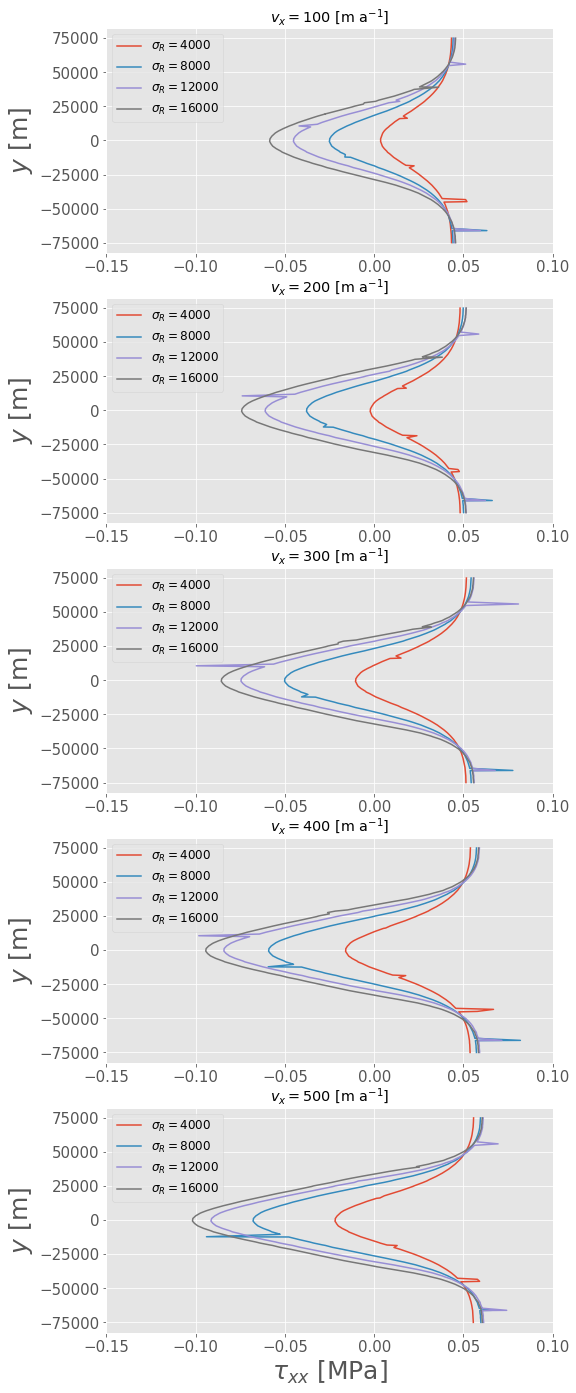

In [11]:
# Plot the deviatoric stress in the x-direction

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(devstress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                    list(devstress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),  \
                    label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-0.15, 0.1])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_x = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$\tau_{xx}$ [MPa]', size=25)
fig.savefig('../Figures/stress1_sigma.jpg', format='jpg', dpi=700, bbox_inches = "tight")


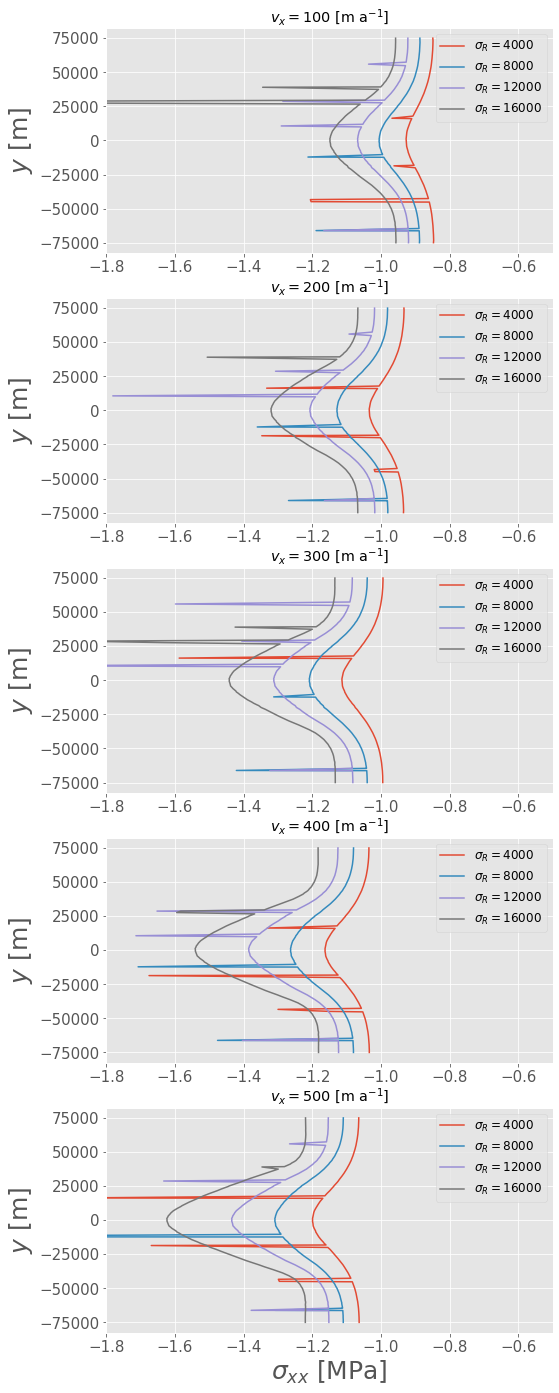

In [12]:
# Plot the stress in the x-direction

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(stress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(stress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-1.8, -0.5])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_x = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$\sigma_{xx}$ [MPa]', size=25)
fig.savefig('../Figures/stress1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


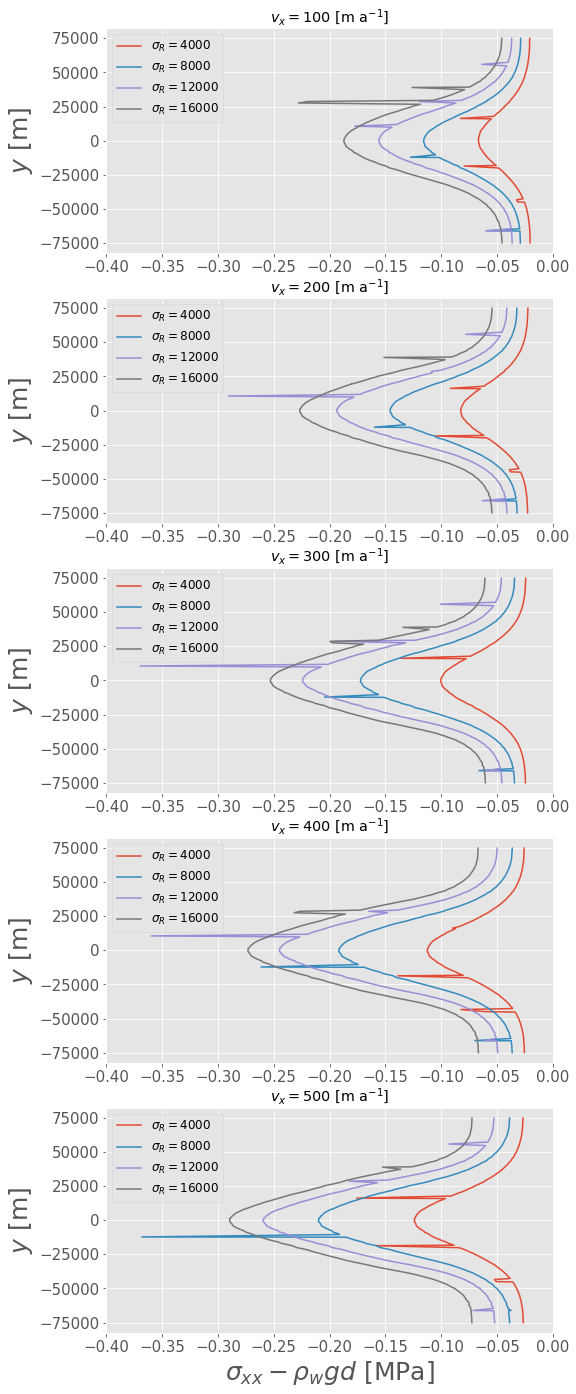

In [13]:
# Plot the stress in the x-direction minus the hydrostatic pressure

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(stress1hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(stress1hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-0.4, 0.0])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_x = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$\sigma_{xx} - \rho_w g d$ [MPa]', size=25)
fig.savefig('../Figures/stress1_hydp.jpg', format='jpg', dpi=700, bbox_inches = "tight")


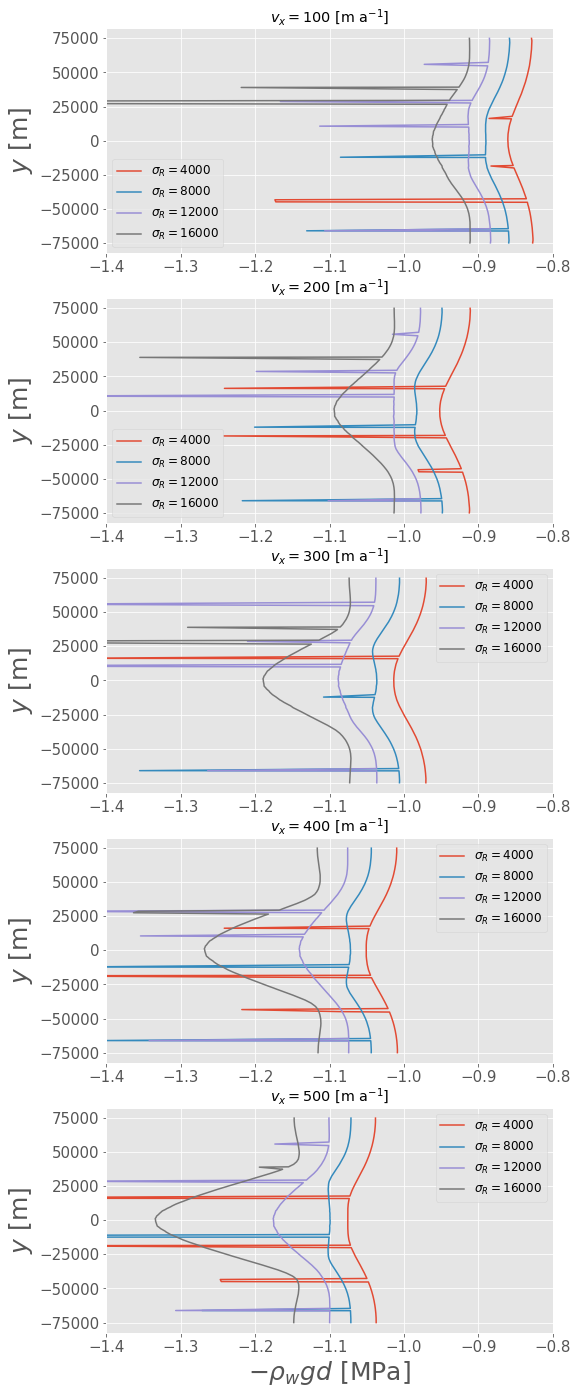

In [21]:
# Plot the hystrostatic pressure

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-1.4, -0.8])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_x = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$- \rho_w g d$ [MPa]', size=25)
fig.savefig('../Figures/hydp.jpg', format='jpg', dpi=700, bbox_inches = "tight")


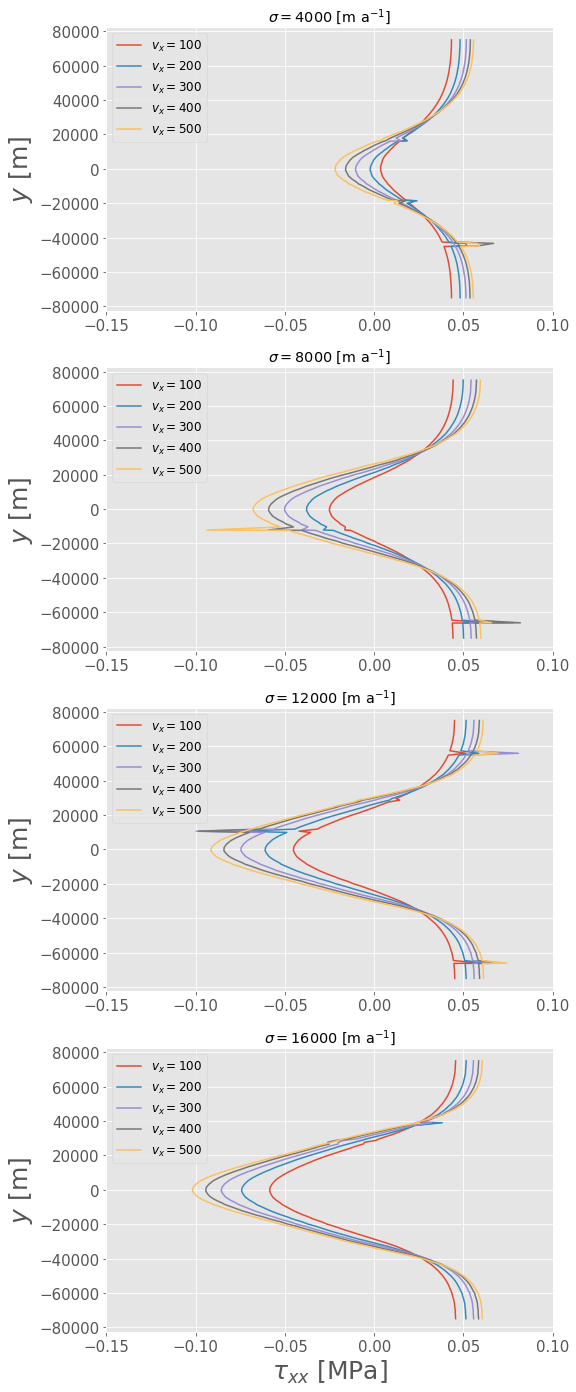

In [22]:
# Plot

fig, ax = plt.subplots(len(sigmas), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[j].plot(list(devstress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(devstress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label=r'$v_x = $' + str(fluxes[i]))  

for i in range(len(sigmas)):
    ax[i].set_xlim([-0.15, 0.1])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$\sigma = $' + str(sigmas[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$\tau_{xx}$ [MPa]', size=25)
fig.savefig('../Figures/stress1_vel.jpg', format='jpg', dpi=700, bbox_inches = "tight")


In [16]:
# Plot the average hydrostatic pressure if the calving front were at this position

def AvHydPressure(g, A, W):
    av_depth = 0.9 * A / (2.0 * W)
    return 0.9 * A * rhow * g * av_depth

#def AvHydPressure(g, A, W):
#    return - 0.9 * A**2 * rhow * g * av_depth * 1e6


In [17]:
# Read in integrated data for each cross-section
# This data is integrated over y and z

Area = {}
StressIntegrated = {}

for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])] = \
        pd.read_csv('../Data/StressIntegrated/AreaFlux' + str(fluxes[i]) \
                    + 'Sigma' + str(sigmas[j]) + '.csv')
            
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])] = \
        pd.read_csv('../Data/StressIntegrated/StressFlux' + str(fluxes[i]) \
                    + 'Sigma' + str(sigmas[j]) + '.csv')
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['dev stress 1'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1'] \
        + StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['pressure']
            
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['hyd p'] = \
        AvHydPressure(g, Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['Area'], 150000)[0]
        
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1 - hyd p'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1'] \
        - StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['hyd p']


In [18]:
StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]

,pressure,stress 1,velocity:0,velocity:1,velocity:2,Points:0,Points:1,Points:2,dev stress 1,hyd p,stress 1 - hyd p
0,62558000.0,-62775000.0,2.103000e+10,-18725000.0,-65703000.0,-45000,-10.225,-121.67,-217000.0,-5.540665e+07,-7368352.704


In [19]:
62775000.0 - 5.540665e+07

7368350.0